<a href="https://colab.research.google.com/github/DataMastersUN/FA_T4/blob/main/Proyecto4G4FdeA2023_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Predicción del número de vehículos registrados en el sistema de tránsito nacional***

## ***Cargue y visualización de datos***

In [1]:
#Librerias a utilizar
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm

# Preprocessing data
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer

# Model Selection for Cross Validation
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split,TimeSeriesSplit

# Machine Learning metrics
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

# ML classifiers
from sklearn.ensemble import (
    HistGradientBoostingClassifier, AdaBoostClassifier,
    RandomForestClassifier, GradientBoostingClassifier,
    StackingClassifier, VotingClassifier
    )
from sklearn.linear_model import LogisticRegression
# Randomizer
import random
# Encoder of categorical variables
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Cargamos la base de datos, le indicamos la ruta en donde se encuentra
data = pd.read_excel('/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto4/data.xlsx')
data

,Fecha,Unidades
0,2012-01-01,0
1,2012-01-02,188
2,2012-01-03,482
3,2012-01-04,927
4,2012-01-05,1159
...,...,...
2187,2017-12-27,2102
2188,2017-12-28,3449
2189,2017-12-29,1084
2190,2017-12-30,18


## ***Modelo de series de tiempo***

Serie diaria

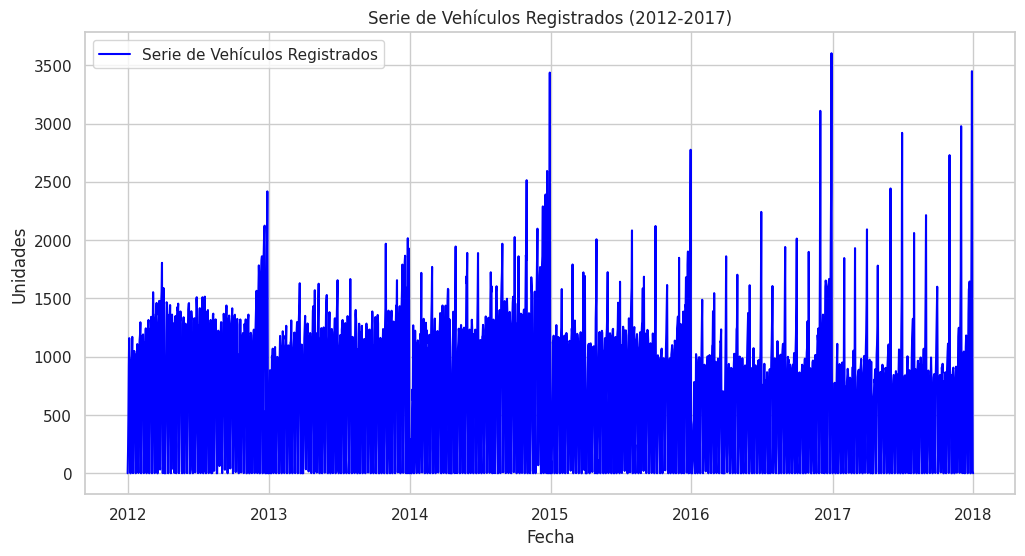

In [ ]:
data['Fecha'] = pd.to_datetime(data['Fecha'])
plt.figure(figsize=(12, 6))
plt.plot(data['Fecha'], data['Unidades'], label='Serie de Vehículos Registrados', color='b')
plt.title('Serie de Vehículos Registrados (2012-2017)')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data_s = data.copy()

In [ ]:
data_s

,Fecha,Unidades
0,2012-01-01,0
1,2012-01-02,188
2,2012-01-03,482
3,2012-01-04,927
4,2012-01-05,1159
...,...,...
2187,2017-12-27,2102
2188,2017-12-28,3449
2189,2017-12-29,1084
2190,2017-12-30,18


In [ ]:
data_s['Fecha'] = pd.to_datetime(data_s['Fecha'])
data_s.set_index('Fecha', inplace=True)

In [ ]:


# Dividir los datos en entrenamiento y validación
train_s = data_s[data_s.index.year < 2017]
val_s = data_s[data_s.index.year == 2017]

# Ajustar el modelo SARIMA
order = (1, 1, 1)  # Parámetros ARIMA
seasonal_order = (1, 1, 1, 7)  # Parámetros SARIMA

model_s = SARIMAX(train_s['Unidades'], order=order, seasonal_order=seasonal_order)
results_s = model_s.fit()

# Realizar predicciones en el conjunto de validación
predictions_s = results_s.get_forecast(steps=len(val_s))
predicted_mean_s = predictions_s.predicted_mean

# Calcular el R2
r2_s = r2_score(val_s['Unidades'], predicted_mean_s)


print(f'R2 en validación: {r2_s}')

R2 en validación: 0.4444746186414211


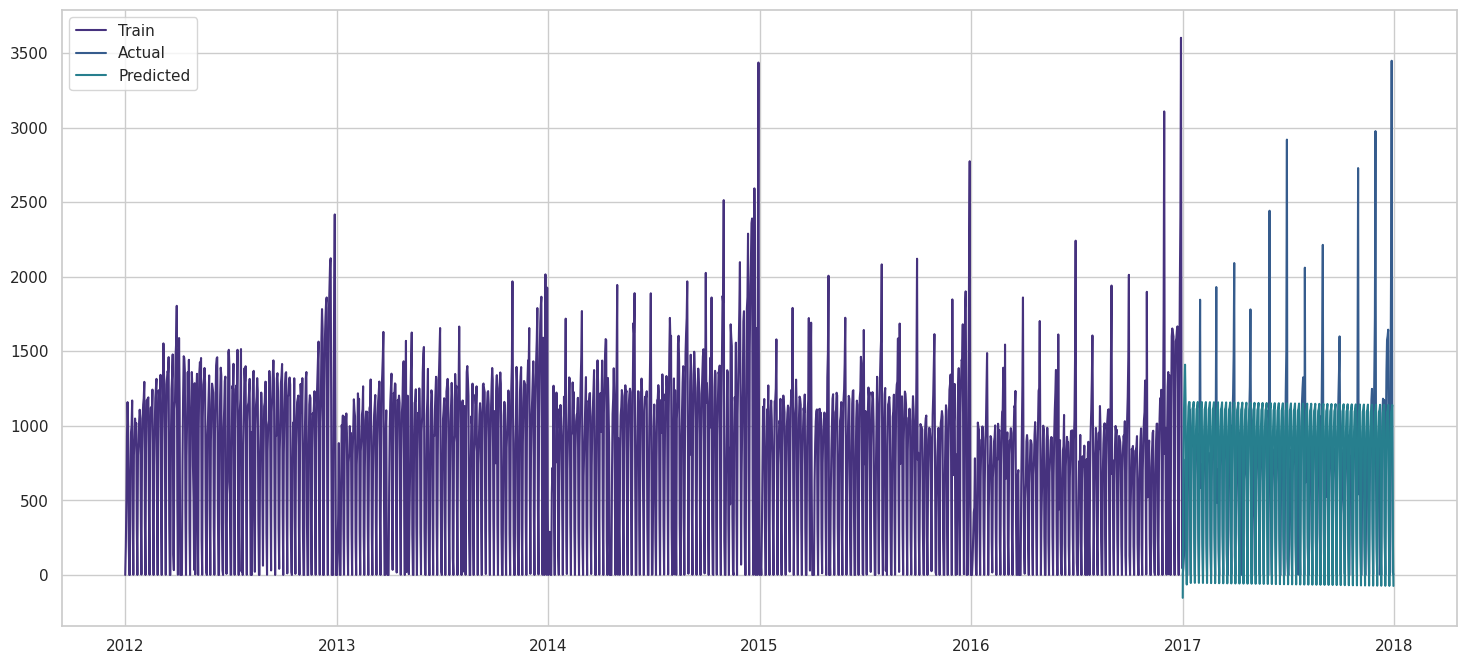

In [ ]:
# Visualizar resultados
plt.figure(figsize=(18, 8))
plt.plot(train_s['Unidades'], label='Train')
plt.plot(val_s['Unidades'], label='Actual')
plt.plot(predicted_mean_s, label='Predicted')
plt.legend()
plt.show()

Serie mensual

In [ ]:
data_agrupada = data.groupby(data['Fecha'].dt.to_period('M')).sum()
data_agrupada

<ipython-input-6-f0f697bc8d99>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_agrupada = data.groupby(data['Fecha'].dt.to_period('M')).sum()


,Unidades
Fecha,
2012-01,20390
2012-02,24840
2012-03,29217
2012-04,23945
2012-05,27066
...,...
2017-08,21029
2017-09,19436
2017-10,19815


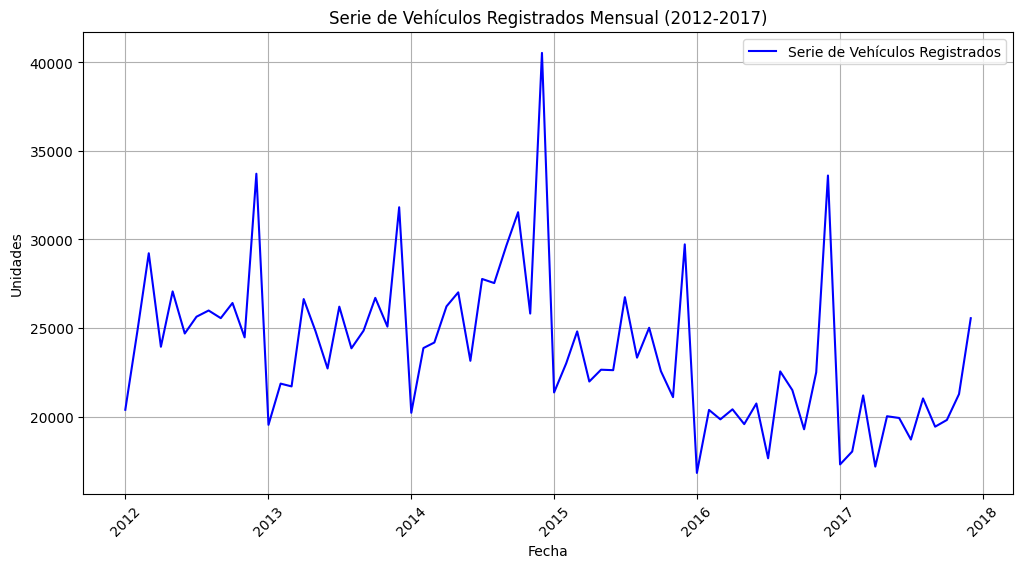

In [ ]:
# Crea un gráfico de la serie de tiempo mensual
plt.figure(figsize=(12, 6))  # Ajusta el tamaño del gráfico según tus preferencias
plt.plot(data_agrupada.index.to_timestamp(), data_agrupada['Unidades'], label='Serie de Vehículos Registrados', color='b')
plt.title('Serie de Vehículos Registrados Mensual (2012-2017)')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para una mejor legibilidad
plt.legend()
plt.grid(True)
plt.show()

A simple vista la serie parecer decrecer a lo largo del tiempo aunque haya un pequeño decrecimiento en 2014 vuelve a descender la cantidad de vehículos en los siguientes años, parece tener componente estacional estocástica, ya que hay ciertos patrones que se repiten en algunos meses año tras año, como lo son el primero y último pico de cada año, pero el patrón o es exactamente el mismo para que la componente sea considerada de estacionalidad deterministica.  No es muy claro si la serie es de componentes aditivas o multiplicativas ya que la amplitud de los datos a lo largo del tiempo en un principio parece ser constante pero luego de 2015 pareciera disminuir es decir que la variabilidad se estuviera reduciendo a lo largo de la tendencia, por lo que podriamos estar dando indicios de que la serie tiene componentes multiplicativas.

In [ ]:
data_agrupada

,Unidades
Fecha,
2012-01,20390
2012-02,24840
2012-03,29217
2012-04,23945
2012-05,27066
...,...
2017-08,21029
2017-09,19436
2017-10,19815


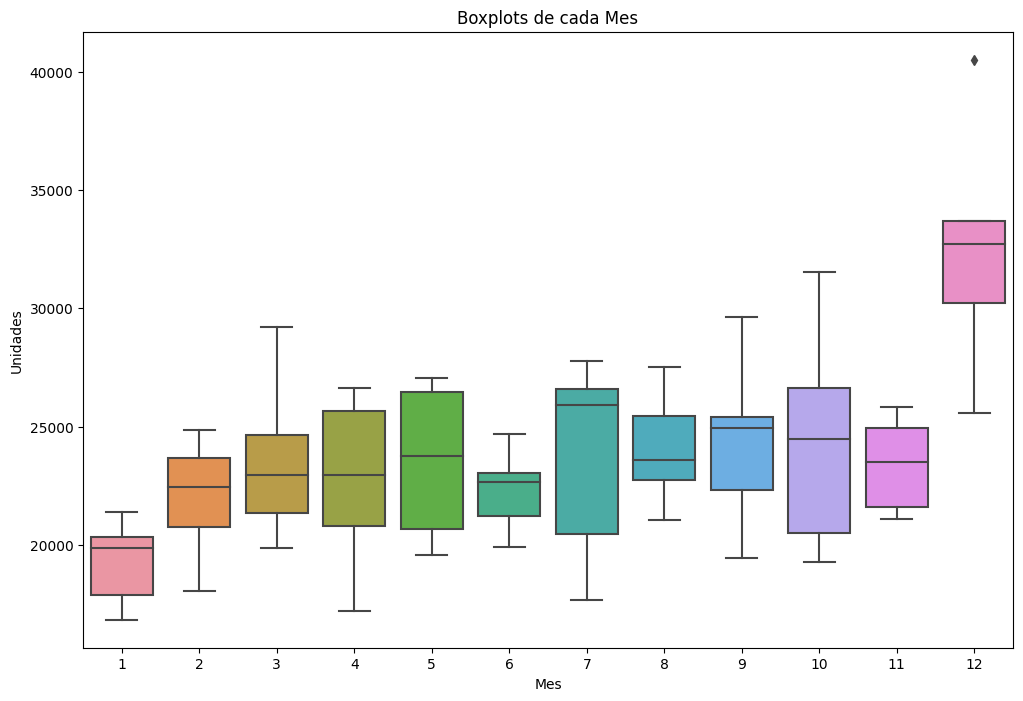

In [ ]:
# Convertir el índice a formato timestamp
data_agrupada.index = data_agrupada.index.to_timestamp()

# Extraer el mes del índice (Fecha)
data_agrupada['Mes'] = data_agrupada.index.month

# Crear una figura y ejes
plt.figure(figsize=(12, 8))

# Crear un boxplot utilizando Seaborn
sns.boxplot(x='Mes', y='Unidades', data=data_agrupada)

# Personalizar la gráfica
plt.title('Boxplots de cada Mes')
plt.xlabel('Mes')
plt.ylabel('Unidades')

# Mostrar la gráfica
plt.show()

A partir de los box-plot se puede que la serie tiene componente estacional ya que la cantidad de unidades de vehículos registrados varía con respecto al mes del año.

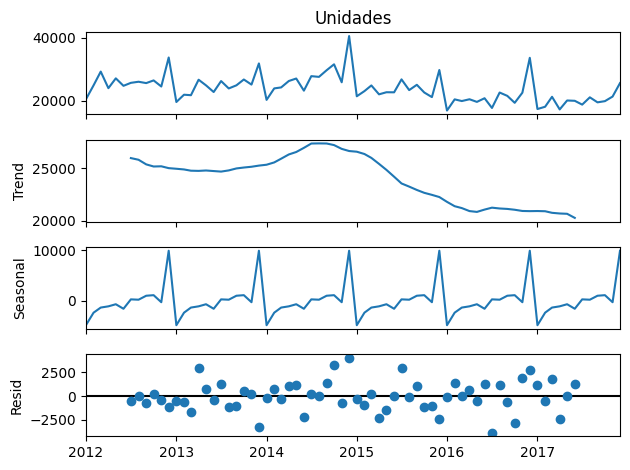

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data_agrupada['Unidades'], model='additive')  # o 'multiplicative'
result.plot()
plt.show()

Vemos la presencia de la componente cíclica en la gráfica de la tendencia, que hace que la función no sea completamente suave, por lo que pordríamos decir que son factibles modelos para la tendencia locales, es decir que cambien en el tiempo.

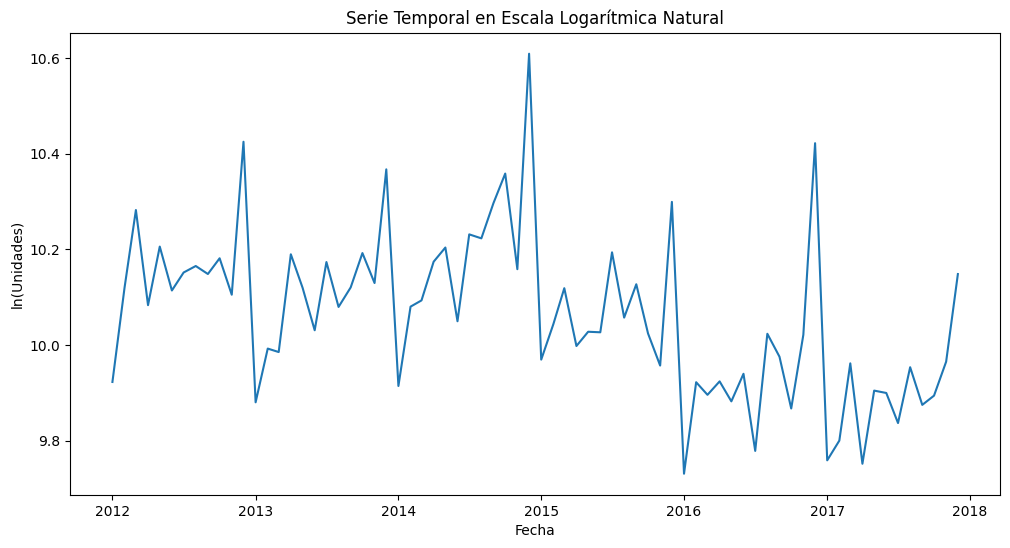

In [ ]:
# Suponiendo que 'Fecha' es el índice y 'Unidades' es la serie
data_agrupada['Fecha'] = pd.to_datetime(data_agrupada.index)

# Aplicar logaritmo natural a los valores de la serie
data_agrupada['Unidades_log'] = np.log(data_agrupada['Unidades'])

# Visualizar la serie en escala logarítmica natural
plt.figure(figsize=(12, 6))
plt.plot(data_agrupada['Fecha'], data_agrupada['Unidades_log'])
plt.title('Serie Temporal en Escala Logarítmica Natural')
plt.xlabel('Fecha')
plt.ylabel('ln(Unidades)')
plt.show()

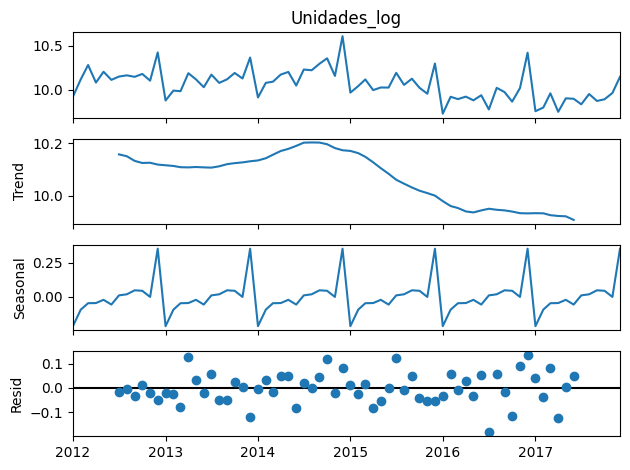

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data_agrupada['Unidades_log'], model='additive')  # o 'multiplicative'
result.plot()
plt.show()

### ***Pruebas de estacionariedad***

In [ ]:
result = adfuller(data_agrupada['Unidades'], autolag='AIC')
print('Estadísticas de la prueba ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])
print('\nResultado de la prueba:')
if result[1] <= 0.05:
    print('La serie temporal es estacionaria.')
else:
    print('La serie temporal no es estacionaria.')

Estadísticas de la prueba ADF: -0.34684206896527947
Valor p: 0.9186031004429176
Valores críticos: {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}

Resultado de la prueba:
La serie temporal no es estacionaria.


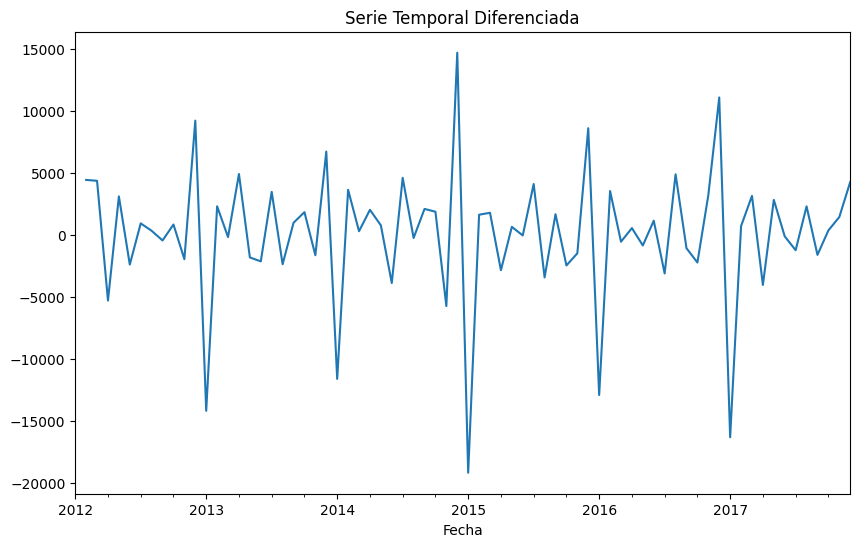

Estadísticas de la prueba ADF para la serie diferenciada: -3.3863202118574516
Valor p para la serie diferenciada: 0.011434148950074111
La serie diferenciada es estacionaria.


In [ ]:
# Realiza la diferenciación de primer orden
data_agrupada['Unidades_diff'] = data_agrupada['Unidades'].diff()

# Visualiza la serie temporal diferenciada
data_agrupada['Unidades_diff'].plot(figsize=(10, 6), title='Serie Temporal Diferenciada')
plt.show()

# Realiza la prueba ADF en la serie diferenciada
result_diff = adfuller(data_agrupada['Unidades_diff'].dropna(), autolag='AIC')
print('Estadísticas de la prueba ADF para la serie diferenciada:', result_diff[0])
print('Valor p para la serie diferenciada:', result_diff[1])

# Verifica si la serie diferenciada es estacionaria
if result_diff[1] <= 0.05:
    print('La serie diferenciada es estacionaria.')
else:
    print('La serie diferenciada no es estacionaria.')

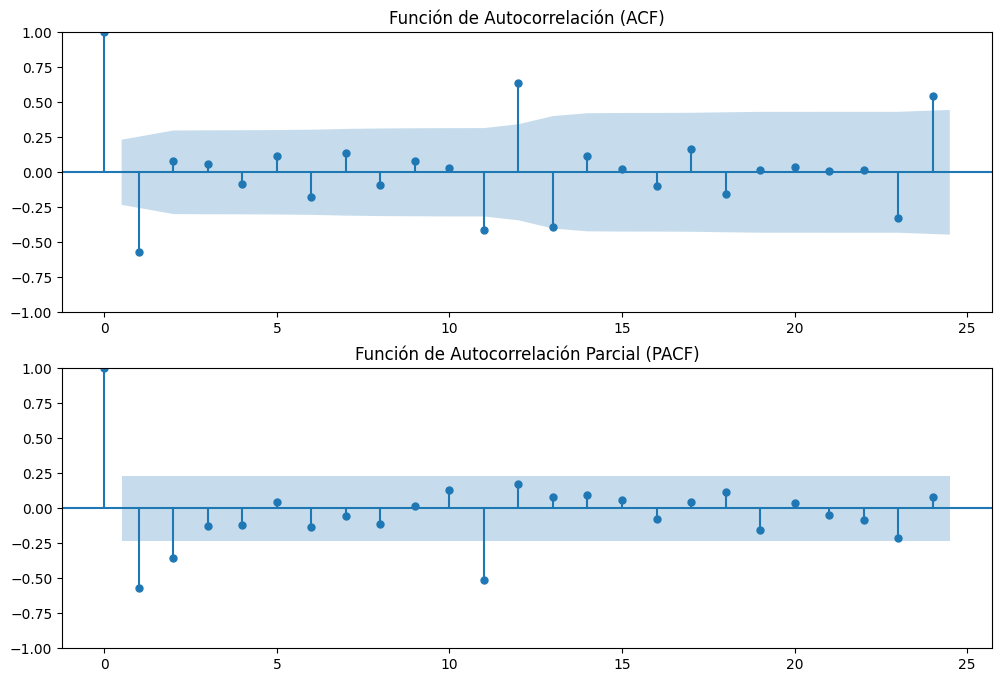

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Visualizar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) de la serie diferenciada
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelación
plot_acf(data_agrupada['Unidades_diff'].dropna(), lags=24, ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF)')

# Autocorrelación Parcial
plot_pacf(data_agrupada['Unidades_diff'].dropna(), lags=24, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF)')

plt.show()

(2,1,1)

(1,1,1)

In [ ]:
# Descomposición estacional
m = 12  # Supongamos que la serie es mensual
decomposition = sm.tsa.seasonal_decompose(data_agrupada['Unidades_diff'].dropna(), period=m)

# Serie diferenciada estacionalmente
serie_diferenciada_estacional = decomposition.seasonal.dropna()
# Prueba ADF en la serie diferenciada estacionalmente
resultado_adf_diferenciada_estacional = adfuller(serie_diferenciada_estacional)
estadistica_adf_diferenciada_estacional = resultado_adf_diferenciada_estacional[0]
p_valor_adf_diferenciada_estacional = resultado_adf_diferenciada_estacional[1]

print(f"Estadística ADF (diferenciada estacionalmente): {estadistica_adf_diferenciada_estacional}")
print(f"Valor p (diferenciada estacionalmente): {p_valor_adf_diferenciada_estacional}")

if p_valor_adf_diferenciada_estacional <= 0.05:
    print("La serie diferenciada estacionalmente es estacionaria.")
else:
    print("La serie diferenciada estacionalmente no es estacionaria.")

Estadística ADF (diferenciada estacionalmente): -434924956157110.06
Valor p (diferenciada estacionalmente): 0.0
La serie diferenciada estacionalmente es estacionaria.


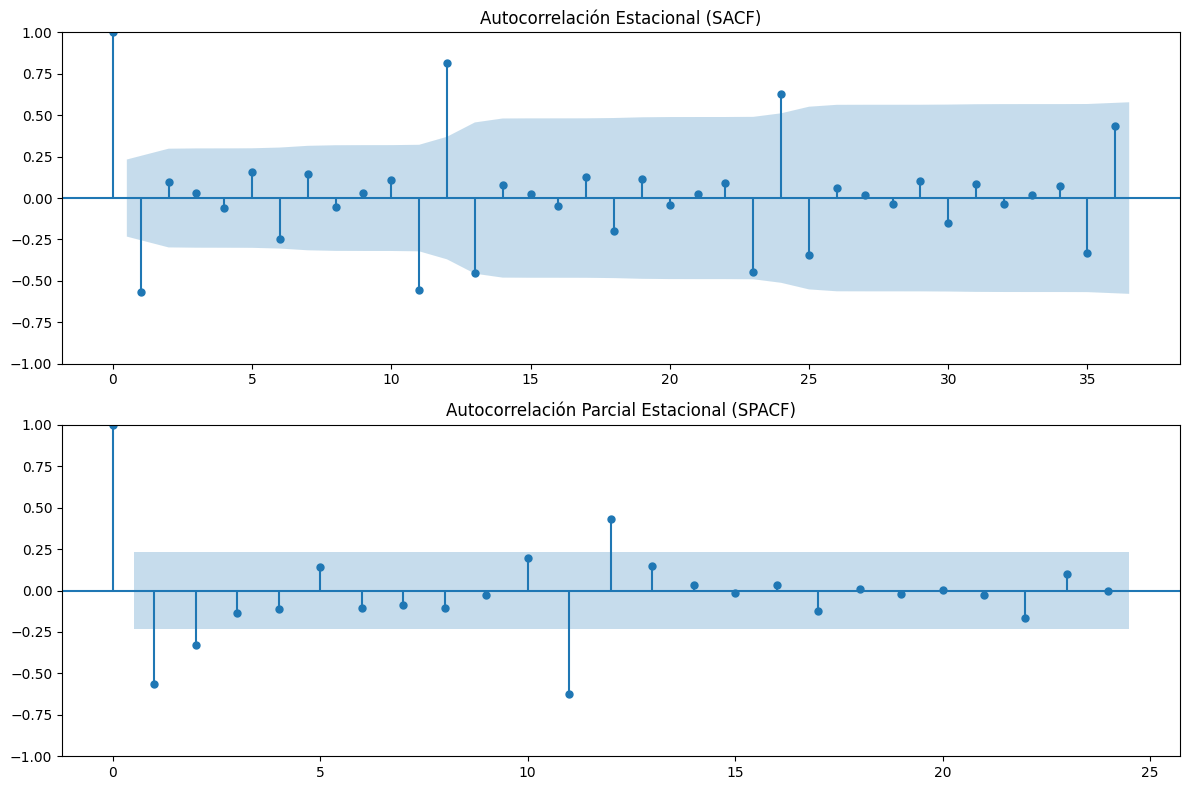

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf

# Descomposición estacional de la serie
m = 12  # Supongamos que la serie es mensual y tiene un patrón estacional anual
decomposition = seasonal_decompose(data_agrupada['Unidades_diff'].dropna(), period=m)

# Visualizar la autocorrelación estacional y la autocorrelación parcial estacional en dos figuras separadas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelación Estacional (SACF)
plot_acf(decomposition.seasonal.dropna(), lags=36, ax=ax1, title='Autocorrelación Estacional (SACF)')

# Autocorrelación Parcial Estacional (SPACF)
plot_pacf(decomposition.seasonal.dropna(), lags=24, ax=ax2, method='ldb', title='Autocorrelación Parcial Estacional (SPACF)')

plt.tight_layout()
plt.show()


(1,0,2)[12]

(1,0,1)[12]

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Supongamos que 'data_agrupada' es tu DataFrame con la serie temporal
# Asegúrate de que 'Fecha' es tu índice y 'Unidades' es tu serie temporal

# Utilizando auto_arima para encontrar el orden óptimo
model = pm.auto_arima(data_agrupada['Unidades'], seasonal=True, m=12)
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood                -691.971
Date:                                 Sun, 12 Nov 2023   AIC                           1391.943
Time:                                         19:53:21   BIC                           1400.994
Sample:                                     01-01-2012   HQIC                          1395.542
                                          - 12-01-2017                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6264      0.059    -10.635      0.000      -0.742      -0

SARIMA (0,1,1)(0,0,2)[12]
SARIMA (0,1,1)(0,0,1)[12]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
# Ajustar el modelo SARIMA
modelo1_sarima = SARIMAX(data_agrupada['Unidades'][:-12], order=(2, 1, 1), seasonal_order=(0, 0, 1, 12))
resultado1_sarima = modelo1_sarima.fit()

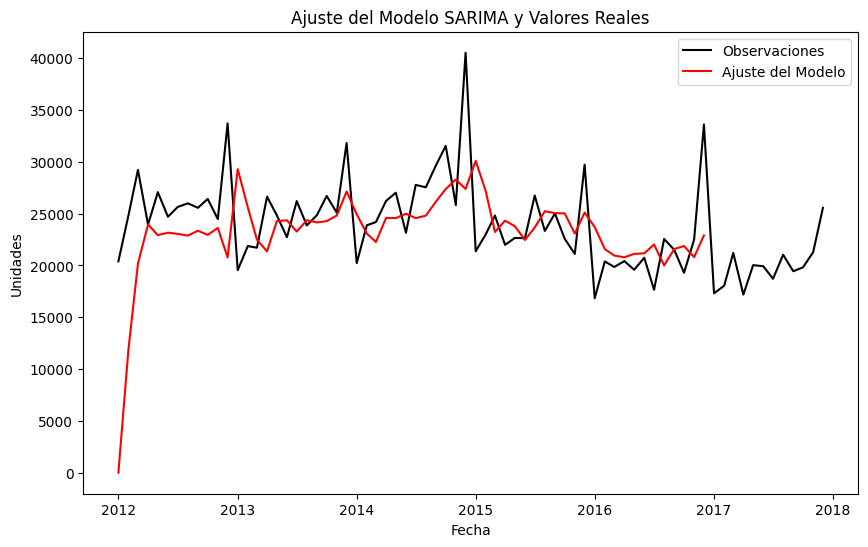

In [ ]:
# Obtener los valores ajustados del modelo
valores_ajustados = resultado1_sarima.fittedvalues

# Graficar los valores ajustados y los valores reales
plt.figure(figsize=(10, 6))
plt.plot(data_agrupada['Unidades'], label='Observaciones', color='black')
plt.plot(valores_ajustados, label='Ajuste del Modelo', color='red')
plt.title('Ajuste del Modelo SARIMA y Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.show()

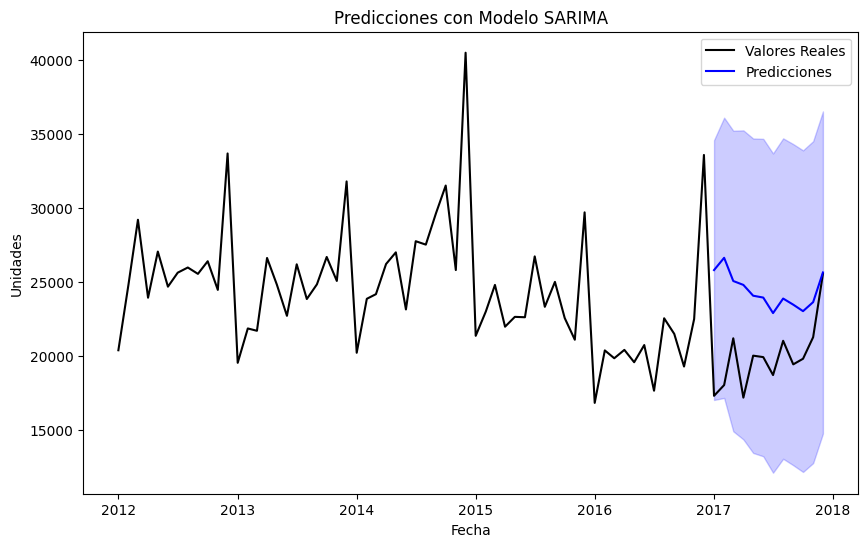

In [ ]:
# Realizar predicciones para los últimos 12 meses
predicciones = resultado1_sarima.get_forecast(steps=12)
intervalo_confianza = predicciones.conf_int()

# Graficar las predicciones, valores reales y el intervalo de confianza
plt.figure(figsize=(10, 6))
plt.plot(data_agrupada['Unidades'], label='Valores Reales', color='black')
plt.plot(predicciones.predicted_mean, label='Predicciones', color='blue')
plt.fill_between(intervalo_confianza.index, intervalo_confianza.iloc[:, 0], intervalo_confianza.iloc[:, 1], color='blue', alpha=0.2)
plt.title('Predicciones con Modelo SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.show()

In [ ]:
# Crear un DataFrame con valores reales y pronosticados
df_predicciones = pd.DataFrame({
    'Fecha': data_agrupada.index[-12:],
    'Valores_Reales': data_agrupada['Unidades'][-12:].values,
    'Pronosticados': predicciones.predicted_mean.values,
    'Intervalo_Inferior': intervalo_confianza.iloc[:, 0].values,
    'Intervalo_Superior': intervalo_confianza.iloc[:, 1].values
})

# Mostrar el DataFrame
df_predicciones

,Fecha,Valores_Reales,Pronosticados,Intervalo_Inferior,Intervalo_Superior
0,2017-01-01,17307,25812.608717,17025.918666,34599.298767
1,2017-02-01,18036,26644.782143,17163.867088,36125.697198
2,2017-03-01,21200,25073.738971,14906.627809,35240.850133
3,2017-04-01,17184,24810.795880,14357.915479,35263.676281
4,2017-05-01,20025,24079.709655,13443.873854,34715.545456
5,2017-06-01,19926,23954.136290,13216.970359,34691.302222
6,2017-07-01,18711,22904.481015,12104.892883,33704.069148
7,2017-08-01,21029,23887.486739,13049.683973,34725.289505
8,2017-09-01,19436,23474.260611,12612.069869,34336.451352
9,2017-10-01,19815,23035.325650,12157.282017,33913.369284


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
# Ajustar el modelo SARIMA
modelo2_sarima = SARIMAX(data_agrupada['Unidades'][:-12], order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
resultado2_sarima = modelo2_sarima.fit()

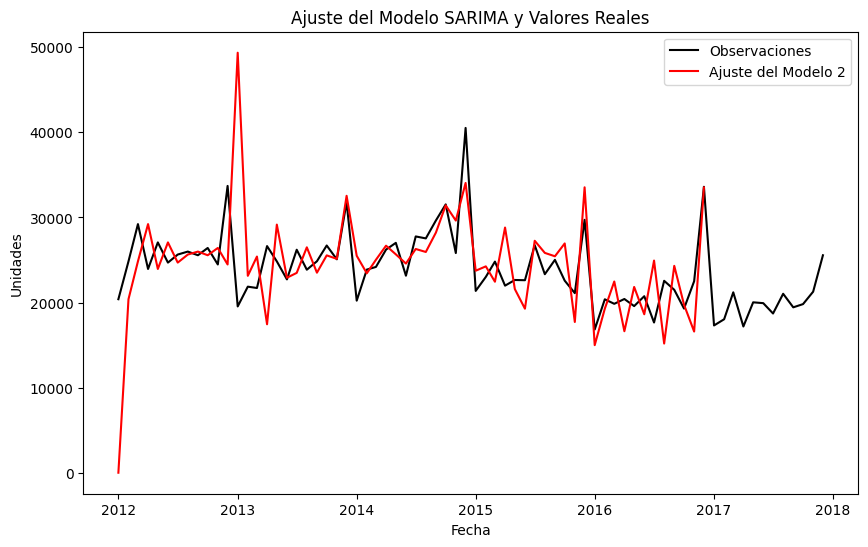

In [ ]:
# Obtener los valores ajustados del modelo
valores_ajustados2 = resultado2_sarima.fittedvalues

# Graficar los valores ajustados y los valores reales
plt.figure(figsize=(10, 6))
plt.plot(data_agrupada['Unidades'], label='Observaciones', color='black')
plt.plot(valores_ajustados2, label='Ajuste del Modelo 2', color='red')
plt.title('Ajuste del Modelo SARIMA y Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.show()

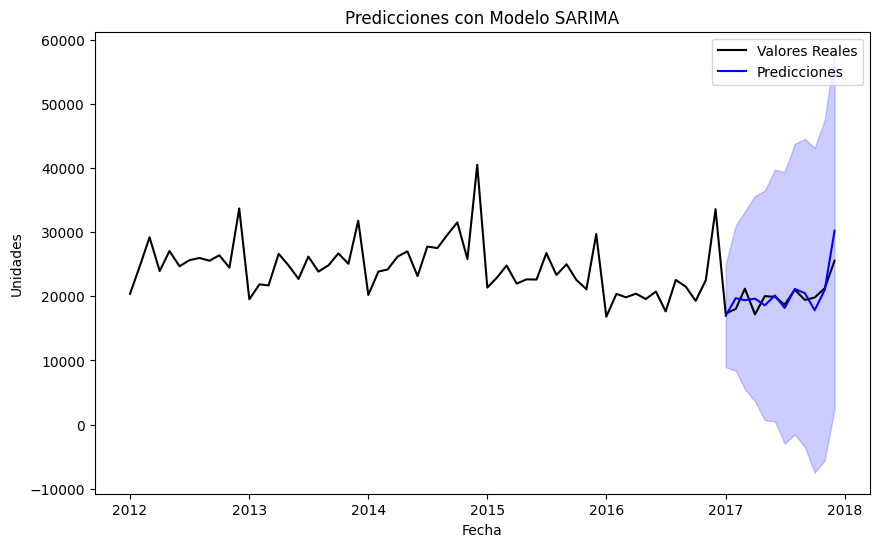

In [ ]:
# Realizar predicciones para los últimos 12 meses
predicciones2 = resultado2_sarima.get_forecast(steps=12)
intervalo_confianza2 = predicciones2.conf_int()

# Graficar las predicciones, valores reales y el intervalo de confianza
plt.figure(figsize=(10, 6))
plt.plot(data_agrupada['Unidades'], label='Valores Reales', color='black')
plt.plot(predicciones2.predicted_mean, label='Predicciones', color='blue')
plt.fill_between(intervalo_confianza2.index, intervalo_confianza2.iloc[:, 0], intervalo_confianza2.iloc[:, 1], color='blue', alpha=0.2)
plt.title('Predicciones con Modelo SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.show()

In [ ]:
# Crear un DataFrame con valores reales y pronosticados
df_predicciones2 = pd.DataFrame({
    'Fecha': data_agrupada.index[-12:],
    'Valores_Reales': data_agrupada['Unidades'][-12:].values,
    'Pronosticados': predicciones2.predicted_mean.values,
    'Intervalo_Inferior': intervalo_confianza2.iloc[:, 0].values,
    'Intervalo_Superior': intervalo_confianza2.iloc[:, 1].values
})
# Mostrar el DataFrame
df_predicciones2

,Fecha,Valores_Reales,Pronosticados,Intervalo_Inferior,Intervalo_Superior
0,2017-01-01,17307,16970.441358,8955.409942,24985.472774
1,2017-02-01,18036,19717.630505,8383.353150,31051.907861
2,2017-03-01,21200,19391.664195,5510.347335,33272.981054
3,2017-04-01,17184,19642.485872,3613.884176,35671.087568
4,2017-05-01,20025,18595.385073,674.972497,36515.797650
5,2017-06-01,19926,20134.615699,503.866821,39765.364576
6,2017-07-01,18711,18185.953709,-3017.617124,39389.524542
7,2017-08-01,21029,21144.363796,-1523.157698,43811.885289
8,2017-09-01,19436,20494.327069,-3548.169582,44536.823720
9,2017-10-01,19815,17823.524879,-7519.457578,43166.507336


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extraer los valores reales y pronosticados
valores_reales = df_predicciones2['Valores_Reales']
valores_pronosticados = df_predicciones2['Pronosticados']

# Calcular MAE
mae = mean_absolute_error(valores_reales, valores_pronosticados)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(valores_reales, valores_pronosticados))

# Calcular MAPE
mape = np.mean(np.abs((valores_reales - valores_pronosticados) / valores_reales)) * 100

# Mostrar los resultados
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 1379.78
RMSE: 1866.76
MAPE: 6.72%


## ***Elección de variables***

In [5]:
data

,Fecha,Unidades
0,2012-01-01,0
1,2012-01-02,188
2,2012-01-03,482
3,2012-01-04,927
4,2012-01-05,1159
...,...,...
2187,2017-12-27,2102
2188,2017-12-28,3449
2189,2017-12-29,1084
2190,2017-12-30,18


In [6]:
data['Fecha'] = pd.to_datetime(data['Fecha'])
data['diaMes'] = data['Fecha'].dt.day
data['diaSemana'] = data['Fecha'].dt.day_name()
data['anio'] = data['Fecha'].dt.year
data['mes'] = data['Fecha'].dt.month
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes
0,2012-01-01,0,1,Sunday,2012,1
1,2012-01-02,188,2,Monday,2012,1
2,2012-01-03,482,3,Tuesday,2012,1
3,2012-01-04,927,4,Wednesday,2012,1
4,2012-01-05,1159,5,Thursday,2012,1
...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12
2188,2017-12-28,3449,28,Thursday,2017,12
2189,2017-12-29,1084,29,Friday,2017,12
2190,2017-12-30,18,30,Saturday,2017,12


In [7]:
import holidays
from datetime import date
festivos = []
años = list(range(2010, 2020))
for año in años:
    festivos_año = holidays.CO(years=año)
    for fecha, nombre in sorted(festivos_año.items()):
        festivos.append((fecha))

In [8]:
data['esFestivo'] = data['Fecha'].isin(festivos).astype(int)
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo
0,2012-01-01,0,1,Sunday,2012,1,1
1,2012-01-02,188,2,Monday,2012,1,0
2,2012-01-03,482,3,Tuesday,2012,1,0
3,2012-01-04,927,4,Wednesday,2012,1,0
4,2012-01-05,1159,5,Thursday,2012,1,0
...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0
2188,2017-12-28,3449,28,Thursday,2017,12,0
2189,2017-12-29,1084,29,Friday,2017,12,0
2190,2017-12-30,18,30,Saturday,2017,12,0


In [9]:
data[data['esFestivo']==1]

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo
0,2012-01-01,0,1,Sunday,2012,1,1
8,2012-01-09,0,9,Monday,2012,1,1
78,2012-03-19,0,19,Monday,2012,3,1
95,2012-04-05,1,5,Thursday,2012,4,1
96,2012-04-06,0,6,Friday,2012,4,1
...,...,...,...,...,...,...,...
2115,2017-10-16,0,16,Monday,2017,10,1
2136,2017-11-06,0,6,Monday,2017,11,1
2143,2017-11-13,0,13,Monday,2017,11,1
2168,2017-12-08,1,8,Friday,2017,12,1


In [10]:
data['esQuincena'] = (data['Fecha'].dt.day.isin([15, 30])).astype(int)
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena
0,2012-01-01,0,1,Sunday,2012,1,1,0
1,2012-01-02,188,2,Monday,2012,1,0,0
2,2012-01-03,482,3,Tuesday,2012,1,0,0
3,2012-01-04,927,4,Wednesday,2012,1,0,0
4,2012-01-05,1159,5,Thursday,2012,1,0,0
...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0,0
2188,2017-12-28,3449,28,Thursday,2017,12,0,0
2189,2017-12-29,1084,29,Friday,2017,12,0,0
2190,2017-12-30,18,30,Saturday,2017,12,0,1


In [11]:
data['diaAnio'] = data['Fecha'].dt.dayofyear
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio
0,2012-01-01,0,1,Sunday,2012,1,1,0,1
1,2012-01-02,188,2,Monday,2012,1,0,0,2
2,2012-01-03,482,3,Tuesday,2012,1,0,0,3
3,2012-01-04,927,4,Wednesday,2012,1,0,0,4
4,2012-01-05,1159,5,Thursday,2012,1,0,0,5
...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0,0,361
2188,2017-12-28,3449,28,Thursday,2017,12,0,0,362
2189,2017-12-29,1084,29,Friday,2017,12,0,0,363
2190,2017-12-30,18,30,Saturday,2017,12,0,1,364


In [12]:
data['esFinDeSemana'] = data.apply(lambda fila: 1 if (fila['diaSemana']=='Saturday' or fila['diaSemana']=='Sunday') else 0,axis=1)
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana
0,2012-01-01,0,1,Sunday,2012,1,1,0,1,1
1,2012-01-02,188,2,Monday,2012,1,0,0,2,0
2,2012-01-03,482,3,Tuesday,2012,1,0,0,3,0
3,2012-01-04,927,4,Wednesday,2012,1,0,0,4,0
4,2012-01-05,1159,5,Thursday,2012,1,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0,0,361,0
2188,2017-12-28,3449,28,Thursday,2017,12,0,0,362,0
2189,2017-12-29,1084,29,Friday,2017,12,0,0,363,0
2190,2017-12-30,18,30,Saturday,2017,12,0,1,364,1


In [13]:
data['ultimoDiaHabilMes'] = (data['Fecha'] + pd.offsets.BMonthEnd(0)).dt.day == data['Fecha'].dt.day
data['ultimoDiaHabilMes'] = data['ultimoDiaHabilMes'].astype(int)
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes
0,2012-01-01,0,1,Sunday,2012,1,1,0,1,1,0
1,2012-01-02,188,2,Monday,2012,1,0,0,2,0,0
2,2012-01-03,482,3,Tuesday,2012,1,0,0,3,0,0
3,2012-01-04,927,4,Wednesday,2012,1,0,0,4,0,0
4,2012-01-05,1159,5,Thursday,2012,1,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0,0,361,0,0
2188,2017-12-28,3449,28,Thursday,2017,12,0,0,362,0,0
2189,2017-12-29,1084,29,Friday,2017,12,0,0,363,0,1
2190,2017-12-30,18,30,Saturday,2017,12,0,1,364,1,0


In [14]:
data_p = data[['Unidades', 'diaMes', 'diaSemana', 'anio', 'mes', 'esFestivo', 'esQuincena', 'diaAnio', 'esFinDeSemana', 'ultimoDiaHabilMes']]
data_p

,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes
0,0,1,Sunday,2012,1,1,0,1,1,0
1,188,2,Monday,2012,1,0,0,2,0,0
2,482,3,Tuesday,2012,1,0,0,3,0,0
3,927,4,Wednesday,2012,1,0,0,4,0,0
4,1159,5,Thursday,2012,1,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...
2187,2102,27,Wednesday,2017,12,0,0,361,0,0
2188,3449,28,Thursday,2017,12,0,0,362,0,0
2189,1084,29,Friday,2017,12,0,0,363,0,1
2190,18,30,Saturday,2017,12,0,1,364,1,0


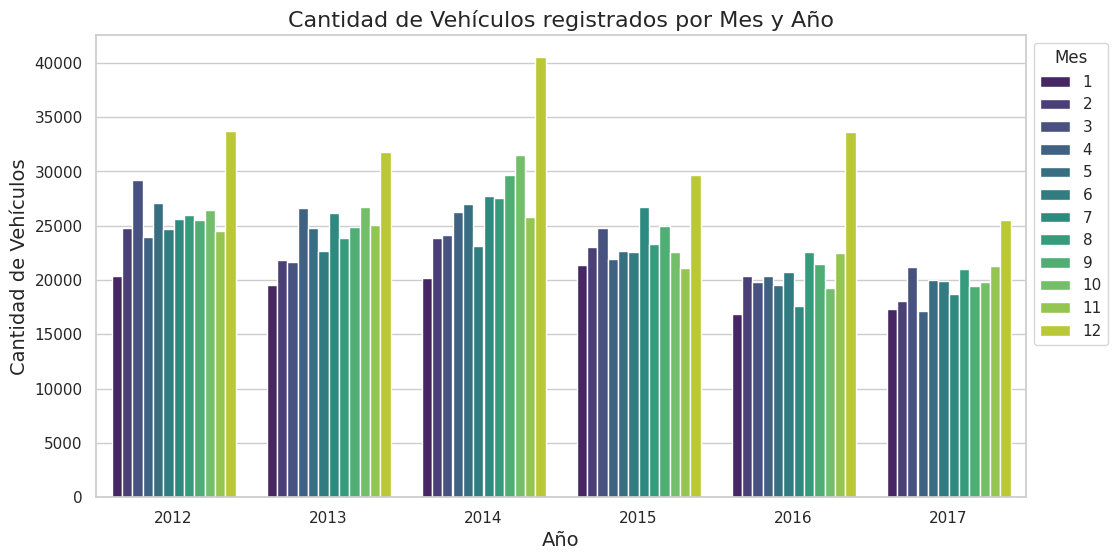

In [15]:
# Convertir la columna 'diaSemana' a tipo categórico para ordenar los días de la semana correctamente
dias_semana_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data_p['diaSemana'] = pd.Categorical(data_p['diaSemana'], categories=dias_semana_ordenados, ordered=True)

# Crear la gráfica utilizando seaborn
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid', palette='viridis')
colors = sns.color_palette("viridis", 12)
# Agrupar por año y mes, sumar las unidades y graficar
sns.barplot(data=data_p, x='anio', y='Unidades', hue='mes', estimator='sum', errorbar=None,palette=colors)

# Configurar el estilo y las etiquetas
plt.title('Cantidad de Vehículos registrados por Mes y Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Cantidad de Vehículos', fontsize=14)
plt.legend(title='Mes', bbox_to_anchor=(1, 1))
plt.show()

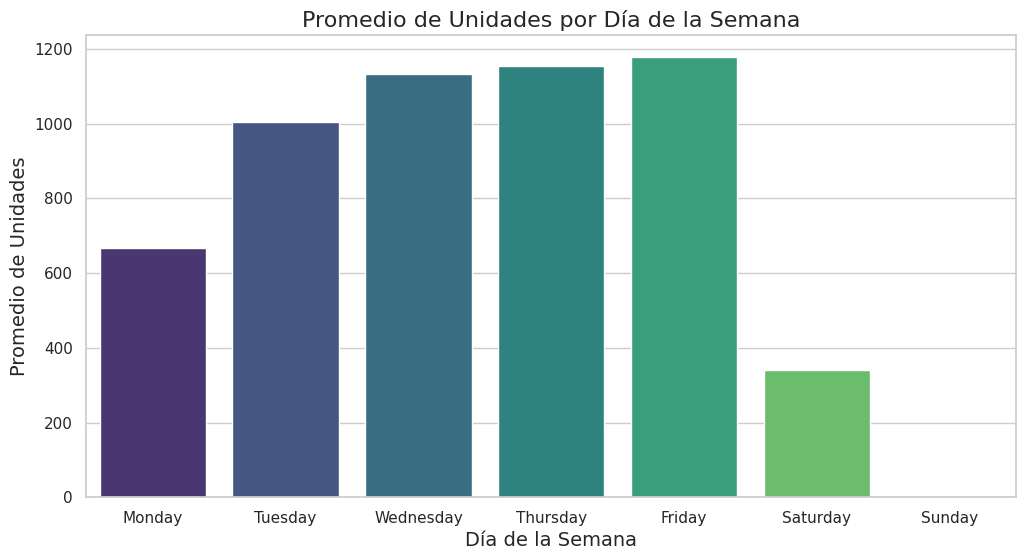

In [16]:
dias_semana_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data_p['diaSemana'] = pd.Categorical(data_p['diaSemana'], categories=dias_semana_ordenados, ordered=True)

# Crear la gráfica utilizando seaborn
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid', palette='viridis')
colors = sns.color_palette("viridis", 7)
# Agrupar por día de la semana, calcular el promedio de unidades y graficar
sns.barplot(data=data_p, x='diaSemana', y='Unidades', estimator='mean', errorbar=None,palette=colors)

# Configurar el estilo y las etiquetas
plt.title('Promedio de Unidades por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=14)
plt.ylabel('Promedio de Unidades', fontsize=14)
plt.show()

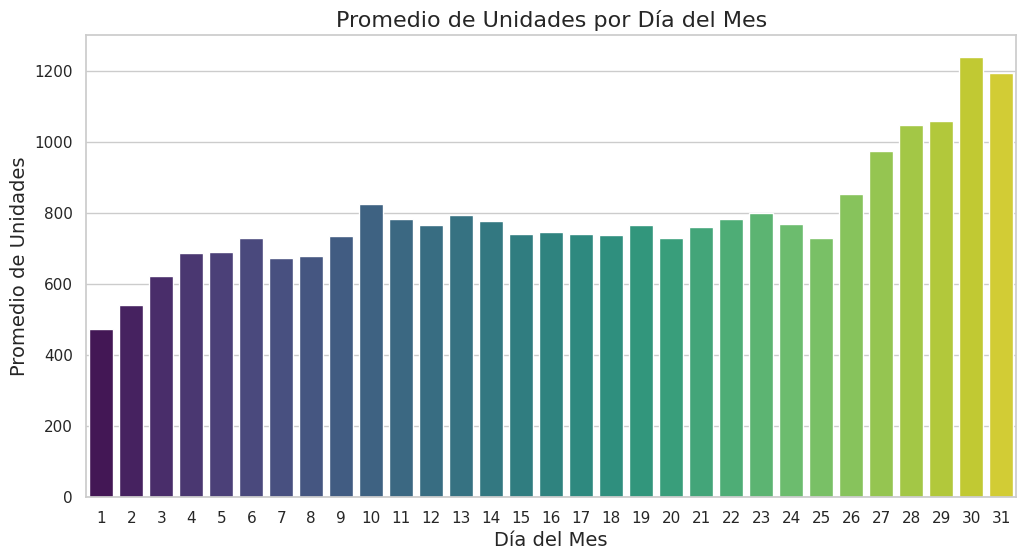

In [17]:
plt.figure(figsize=(12, 6))
colors = sns.color_palette("viridis", 31)

# Agrupar por día del mes, calcular el promedio de unidades y graficar
sns.barplot(data=data_p, x='diaMes', y='Unidades', estimator='mean',  errorbar=None,palette=colors)

# Configurar el estilo y las etiquetas
plt.title('Promedio de Unidades por Día del Mes', fontsize=16)
plt.xlabel('Día del Mes', fontsize=14)
plt.ylabel('Promedio de Unidades', fontsize=14)
plt.show()

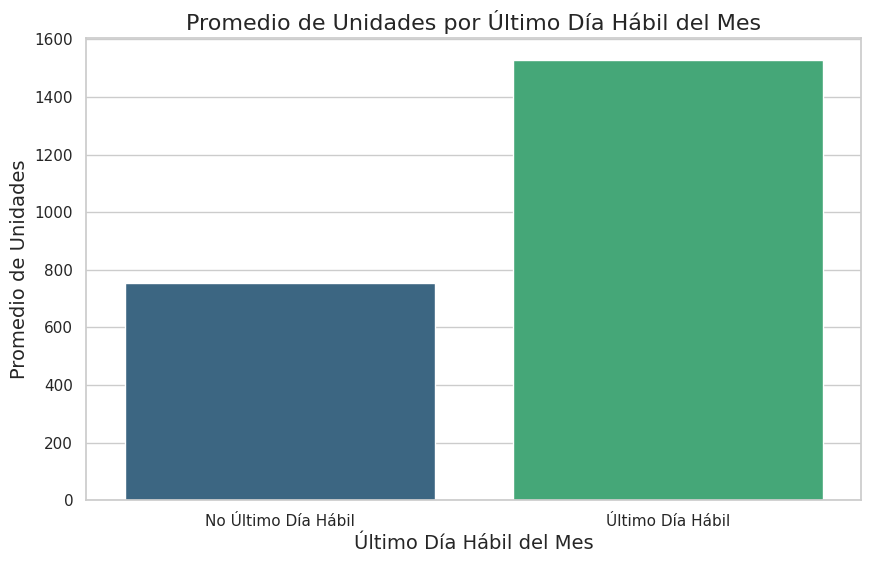

In [18]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", 2)

# Agrupar por si es último día hábil del mes o no, calcular el promedio de unidades y graficar
sns.barplot(data=data_p, x='ultimoDiaHabilMes', y='Unidades', estimator='mean', errorbar=None,palette=colors)

# Configurar el estilo y las etiquetas
plt.title('Promedio de Unidades por Último Día Hábil del Mes', fontsize=16)
plt.xlabel('Último Día Hábil del Mes', fontsize=14)
plt.ylabel('Promedio de Unidades', fontsize=14)
plt.xticks([0, 1], ['No Último Día Hábil', 'Último Día Hábil'])  # Etiquetas para el eje x

plt.show()

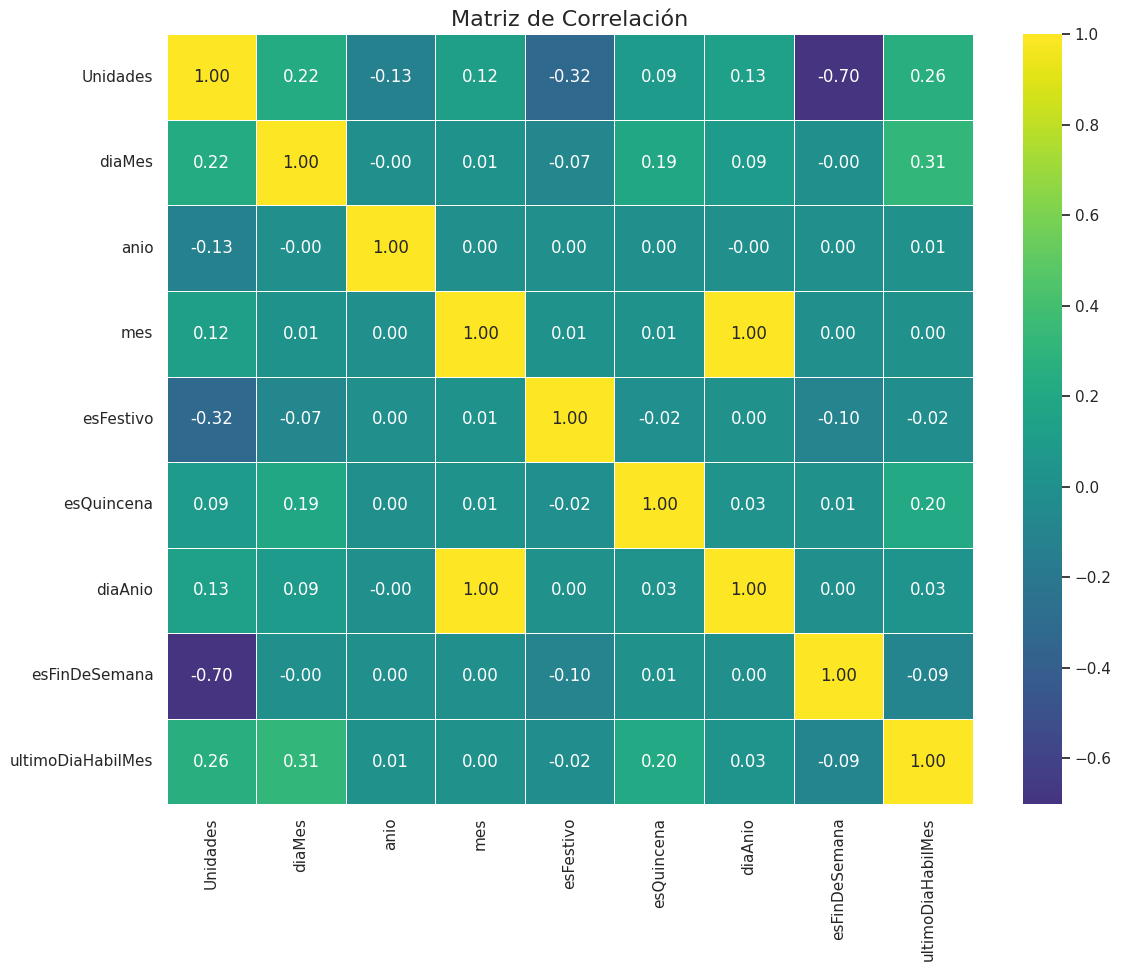

In [19]:
correlation_matrix = data_p.corr(numeric_only=True)
plt.figure(figsize=(13, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

In [20]:
data_p = pd.get_dummies(data_p, columns=['diaSemana'], prefix='diaSemana', drop_first=True)
data_p

,Unidades,diaMes,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes,diaSemana_Tuesday,diaSemana_Wednesday,diaSemana_Thursday,diaSemana_Friday,diaSemana_Saturday,diaSemana_Sunday
0,0,1,2012,1,1,0,1,1,0,0,0,0,0,0,1
1,188,2,2012,1,0,0,2,0,0,0,0,0,0,0,0
2,482,3,2012,1,0,0,3,0,0,1,0,0,0,0,0
3,927,4,2012,1,0,0,4,0,0,0,1,0,0,0,0
4,1159,5,2012,1,0,0,5,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2102,27,2017,12,0,0,361,0,0,0,1,0,0,0,0
2188,3449,28,2017,12,0,0,362,0,0,0,0,1,0,0,0
2189,1084,29,2017,12,0,0,363,0,1,0,0,0,1,0,0
2190,18,30,2017,12,0,1,364,1,0,0,0,0,0,1,0


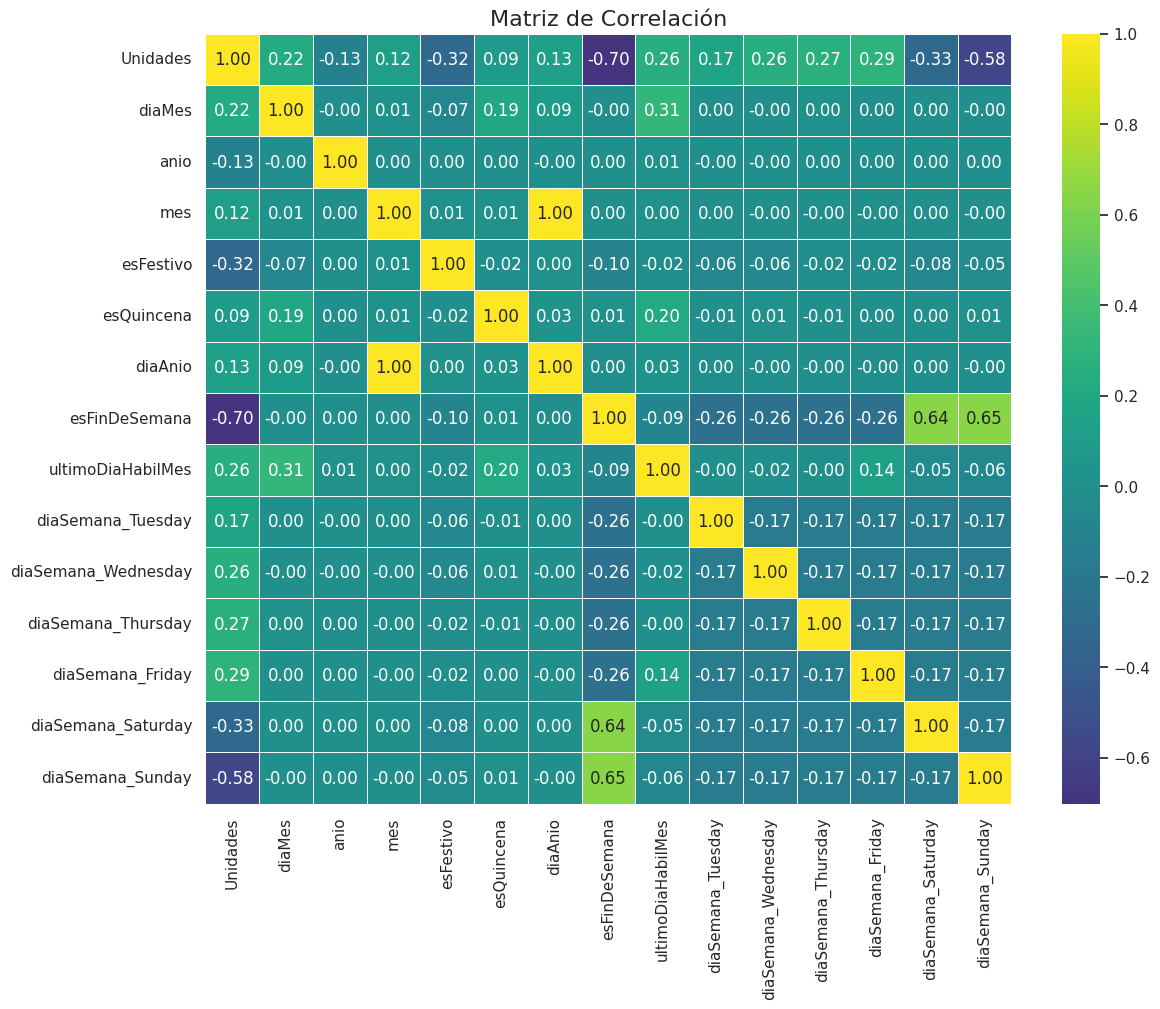

In [21]:
correlation_matrix = data_p.corr(numeric_only=True)
plt.figure(figsize=(13, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

Como se puede apreciar las variables diaAnio y mes están correlacionadas, por lo que se va eliminar diaAnio ya que tiene menos efecto sobre la variable de interés.

In [ ]:
data_p = data_p.drop(columns='mes',axis=True)

In [ ]:
data_a = data_p.copy()

## ***Ajuste de modelos***

In [ ]:
data_train = data_p[data_p['anio'] < 2017]
data_val = data_p[data_p['anio'] == 2017]

### ***1***

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Dividir los datos en características (X) y la variable objetivo (y)
X_train = data_train.drop(['Unidades'], axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop(['Unidades'], axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo de regresión lineal múltiple
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predecir con el conjunto de entrenamiento y validación
y_pred_train = linear_model.predict(X_train)
y_pred_val = linear_model.predict(X_val)

# Calcular R2 para entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

# Imprimir los resultados
print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')

R2 de entrenamiento: 0.8093743708241574
R2 de validación: 0.6912284849578867


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Separar las variables predictoras y la variable de respuesta
X_train = data_train.drop('Unidades', axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop('Unidades', axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo ElasticNet
elasticnet_model = ElasticNet(alpha=0.5, l1_ratio=0.5)
elasticnet_model.fit(X_train, y_train)

# Predecir en los conjuntos de entrenamiento y validación
y_pred_train = elasticnet_model.predict(X_train)
y_pred_val = elasticnet_model.predict(X_val)

# Calcular las métricas en los conjuntos de entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
mse_val = mean_squared_error(y_val, y_pred_val)

# Calcular el porcentaje de variación entre entrenamiento y validación
r2_difference_percentage = ((r2_train-r2_val ) /r2_train) * 100
mse_difference_percentage = ((mse_val - mse_train) / mse_val) * 100

# Imprimir los resultados
print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')
print(f'MSE de entrenamiento: {mse_train}')
print(f'MSE de validación: {mse_val}')
print(f'Diferencia Porcentual entre MSE de Entrenamiento y MSE de Validación: {mse_difference_percentage:.2f}%')

R2 de entrenamiento: 0.5807455605523202
R2 de validación: 0.5518742157849856
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 4.97%
MSE de entrenamiento: 127756.61166207015
MSE de validación: 125112.52019671336
Diferencia Porcentual entre MSE de Entrenamiento y MSE de Validación: -2.11%


### ***2***

### ***3***